# Federated Learning Practice Session #2 

In this notebook, we'll begin to customize the federated learning system we built in the introductory notebook (again, using [Flower](https://flower.ai/) and [PyTorch](https://pytorch.org/)).

## Part 1: Setting up our environment

Let's make sure that we have everything we need.

### 1.1. Installing dependencies

First, we install the necessary packages:

In [ ]:
!pip install -qv flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

Then, let's pull our imports. We'll be using **numpy** for managing weight arrays, **torch** to build our neural networks and **torchvision** for downloading and setting our datasets.

In [25]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader

from flwr_datasets import FederatedDataset
from flwr.common import Metrics

import flwr as fl

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.8.0


### 1.2. Data loading

Let's use the newer flwr datasets and partition strategies. [Work with fashionMNIST if available, else CIFAR10]

In [5]:
#Some global variables
NUM_CLIENTS = 10
BATCH_SIZE = 32

In [6]:
def load_datasets(partitioner=None): ## <---- Provide a partitioner to this function when doing the later assignment 
    if partitioner is None:
        fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
    else:
        fds = FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        batch["img"] = [transform(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        partition = fds.load_partition(partition_id, "train")
        partition = partition.with_transform(apply_transforms)
        partition = partition.train_test_split(train_size=0.8, seed=42)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets() # <--- You can pass a partitioner here

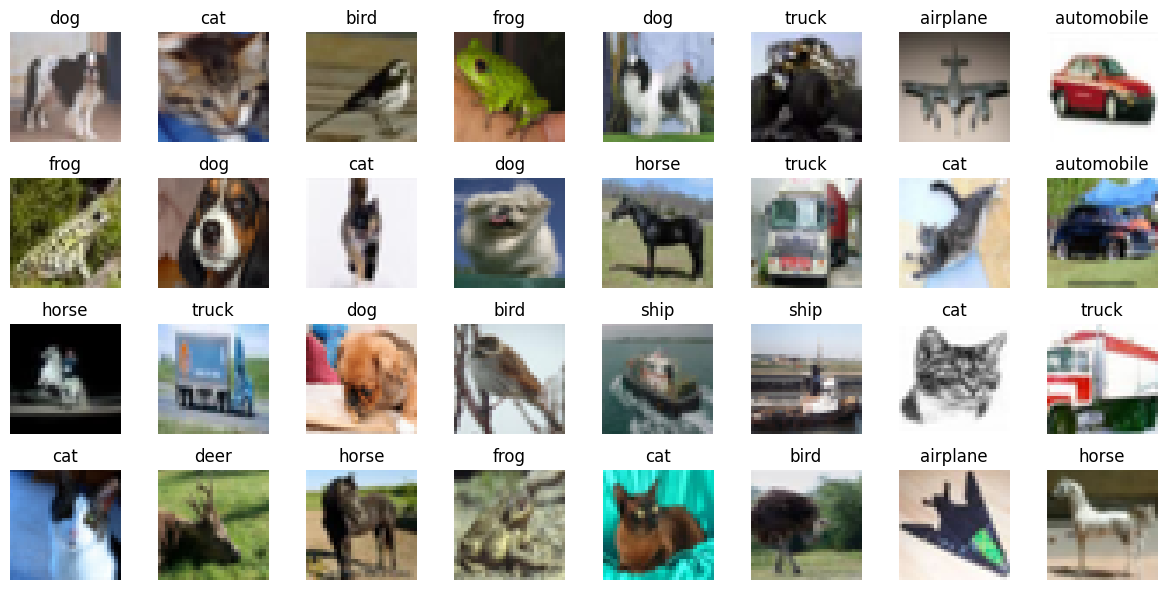

In [7]:
batch = next(iter(trainloaders[0]))
images, labels = batch["img"], batch["label"]
# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloaders[0].dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

### 1.3. Model Definition 

Let's continue with the usual model definition (including `set_parameters` and `get_parameters`), training and test functions:

In [168]:
def Net(classes=10, pretrained=False):
    net = resnet18(weights="DEFAULT")
    net.fc = nn.Linear(512, classes)
    
    return net

class NeuralNetworkManager:
    @staticmethod
    def get_parameters(net) -> List[np.ndarray]:
        params = [val.cpu().numpy() for _, val in net.state_dict().items()]
        return params

    @staticmethod
    def set_parameters(net, parameters: List[np.ndarray]):
        params_dict = zip(net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k:torch.Tensor(v) for k, v in params_dict if len(v.shape) > 0})
        net.load_state_dict(state_dict, strict=False)
        return net

    @staticmethod
    def train(net, trainloader, epochs: int, verbose=False):
        """Train the network on the training set."""
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(net.parameters())
        net.train()
        for epoch in range(epochs):
            correct, total, epoch_loss = 0, 0, 0.0
            for batch in trainloader:
                images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # Metrics
                epoch_loss += loss
                total += labels.size(0)
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            epoch_loss /= len(trainloader.dataset)
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

    @staticmethod
    def test(net, testloader):
        """Evaluate the network on the entire test set."""
        criterion = torch.nn.CrossEntropyLoss()
        correct, total, loss = 0, 0, 0.0
        net.eval()
        with torch.no_grad():
            for batch in testloader:
                images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        loss /= len(testloader.dataset)
        accuracy = correct / total
        return loss, accuracy

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### 1.4. Federating with a Flower client

To implement the Flower client, we (again) create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`. Here, we also pass the `cid` to the client and use it log additional details:

In [18]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader, manager=NeuralNetworkManager):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.manager = manager

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return self.manager.get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        self.manager.set_parameters(self.net, parameters)
        self.manager.train(self.net, self.trainloader, epochs=1)
        return self.manager.get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        self.manager.set_parameters(self.net, parameters)
        loss, accuracy = self.manager.test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [19]:
# A simple client function: Defines a network and sources of data for training and validation
def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

## Part 2: Federated Learning strategies
So far, everything should look familiar if you've worked through the introductory notebook. With that, we're ready to introduce a number of new features.

### 2.1. Leveraging pre-trained models by using **server-side parameter initialization**

Flower, by default, initializes the global model by asking one random client for the initial parameters. In many cases, we want more control over parameter initialization though. Flower therefore allows you to directly pass the initial parameters to the Strategy:

In [20]:
# Create an instance of the model and get the parameters
params = NeuralNetworkManager.get_parameters(Net(pretrained=False))

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 21.8MB/s]
INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2024-05-09 11:32:44,753	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /d

(ClientAppActor pid=22103) [Client 7] fit, config: {}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=22104) [Client 4] evaluate, config: {}
(ClientAppActor pid=22104) [Client 8] fit, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=22103) [Client 6] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=22102) [Client 0] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=22103) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=22103) [Client 1] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 rounds in 239.42s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.05854436914126079\n'
INFO :      	 '\tround 2: 0.044182885805765786\n'
INFO :      	 '\tround 3: 0.03412074716885885\n')
INFO :      


History (loss, distributed):
('\tround 1: 0.05854436914126079\n'
 '\tround 2: 0.044182885805765786\n'
 '\tround 3: 0.03412074716885885\n')

Passing `initial_parameters` to the `FedAvg` strategy prevents Flower from asking one of the clients for the initial parameters. If we look closely, we can see that the logs do not show any calls to the `FlowerClient.get_parameters` method.

### 2.2 Server-side parameter **evaluation**

**Federated Evaluation** (or *client-side evaluation*) is more complex, but also more powerful: it doesn't require a centralized dataset and allows us to evaluate models over a larger set of data, which often yields more realistic evaluation results. In fact, many scenarios require us to use **Federated Evaluation** if we want to get representative evaluation results at all. But this power comes at a cost: once we start to evaluate on the client side, we should be aware that our evaluation dataset can change over consecutive rounds of learning if those clients are not always available. Moreover, the dataset held by each client can also change over consecutive rounds. This can lead to evaluation results that are not stable, so even if we would not change the model, we'd see our evaluation results fluctuate over consecutive rounds.

<div style="max-width:50%; margin-left: auto; margin-right: auto;">
  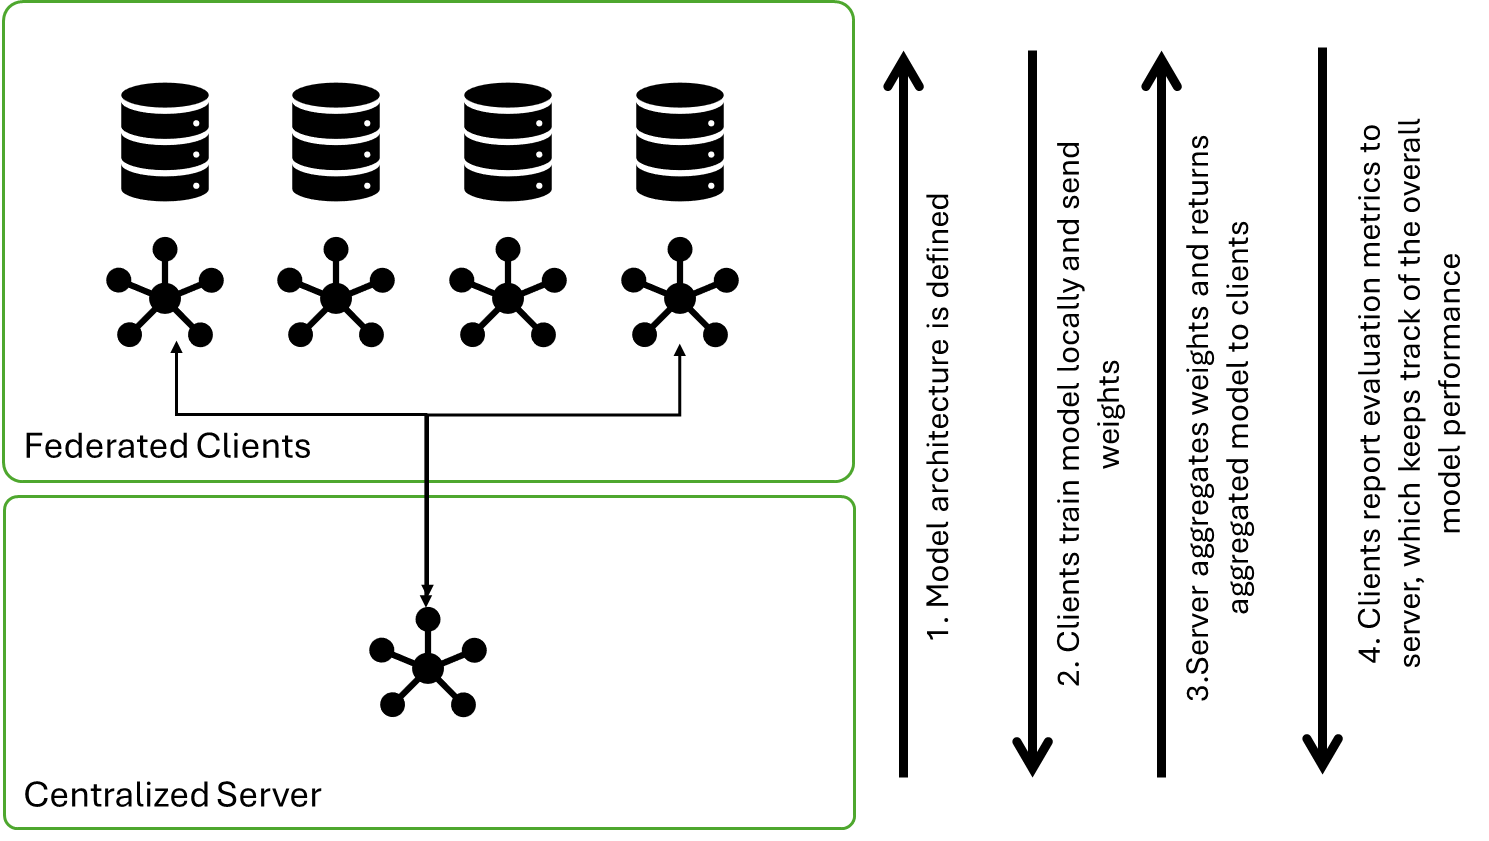
</div>

**Centralized Evaluation** (or *server-side evaluation*) is conceptually simple: it works the same way that evaluation in centralized machine learning does. If there is a server-side dataset that can be used for evaluation purposes, then that's great. We can evaluate the newly aggregated model after each round of training without having to send the model to clients. We're also fortunate in the sense that our entire evaluation dataset is available at all times.

<div style="max-width:50%; margin-left: auto; margin-right: auto;">
  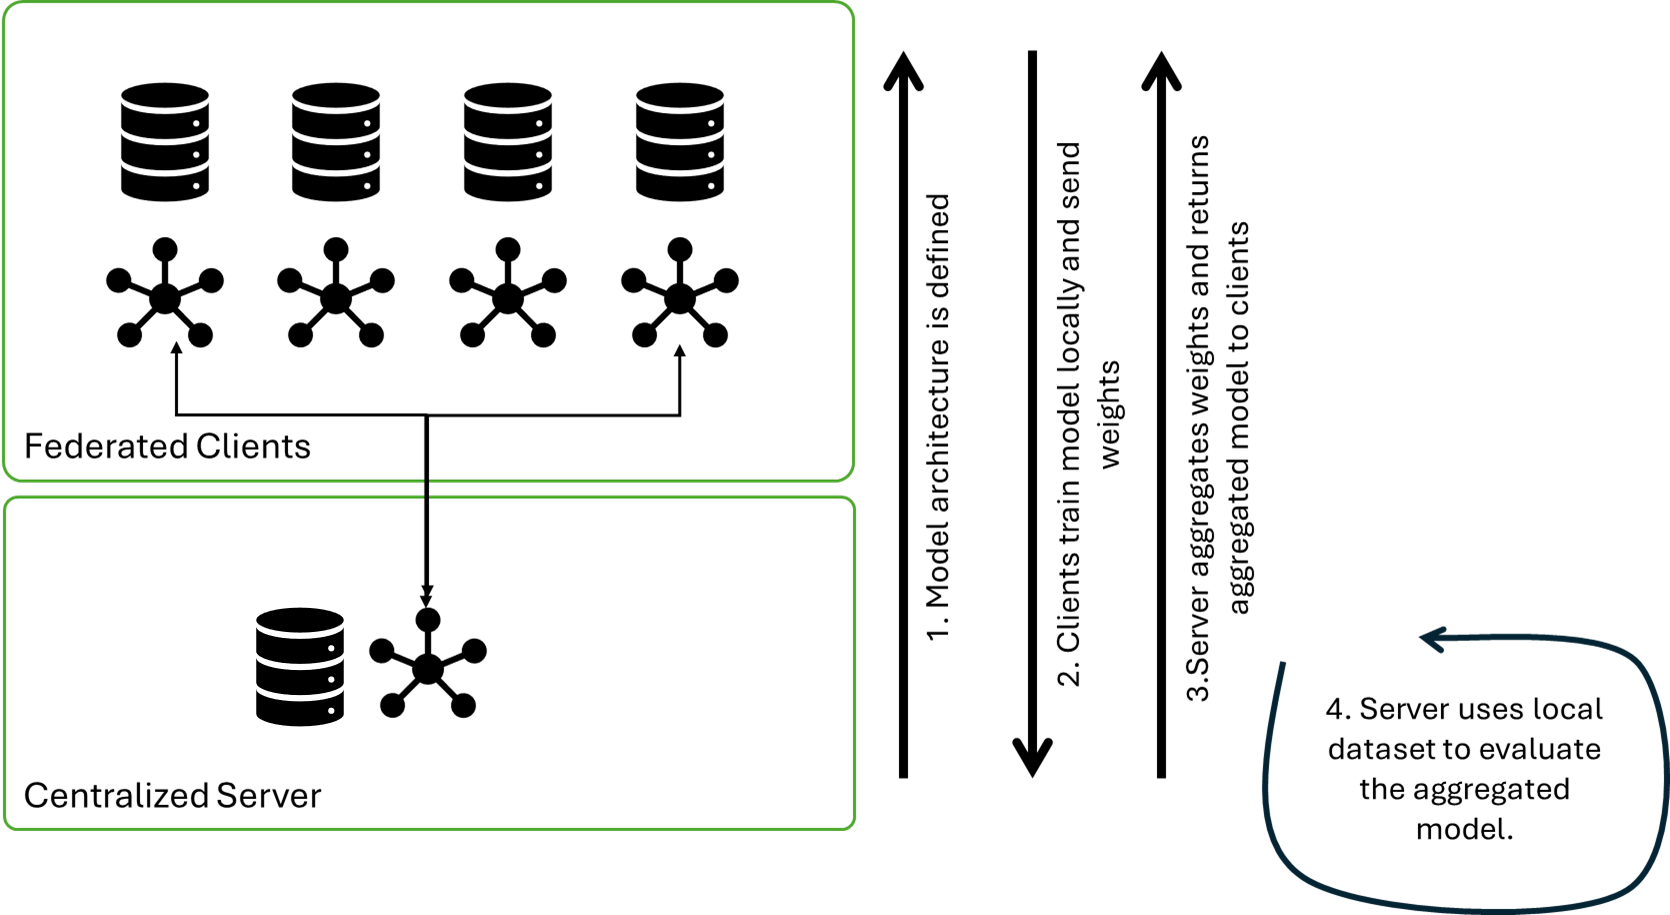
</div>

We've seen how federated evaluation works on the client side (i.e., by implementing the `evaluate` method in `FlowerClient`). Now let's see how we can evaluate aggregated model parameters on the server-side:

In [21]:
# The `evaluate` function will be by Flower called after every round
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net().to(DEVICE)
    
    valloader = valloaders[0]
    
    NeuralNetworkManager.set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = NeuralNetworkManager.test(net, valloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    
    return loss, {"accuracy": accuracy}

In [22]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(NeuralNetworkManager.get_parameters(Net(pretrained=True))),
    # evaluate_metrics_aggregation_fn=weighted_average <--- Federalized Evaluation
    evaluate_fn=evaluate,  # Centralized evaluation
)

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2024-05-09 12:23:26,873	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you 

Server-side evaluation loss 0.07794842910766601 / accuracy 0.067


(ClientAppActor pid=27177) /opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=27177)   warnings.warn(
(ClientAppActor pid=27177) /opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
(ClientAppActor pid=27177)   warnings.warn(msg)


(ClientAppActor pid=27177) [Client 3] fit, config: {}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.06165666735172272, {'accuracy': 0.3}, 68.45486882701516)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.06165666735172272 / accuracy 0.3
(ClientAppActor pid=27178) [Client 8] evaluate, config: {}
(ClientAppActor pid=27179) [Client 2] fit, config: {} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.043946659922599794, {'accuracy': 0.607}, 133.71367832500255)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.043946659922599794 / accuracy 0.607
(ClientAppActor pid=27178) [Client 7] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=27177) [Client 9] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.03395019310712814, {'accuracy': 0.658}, 202.575339271978)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.03395019310712814 / accuracy 0.658
(ClientAppActor pid=27177) [Client 5] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=27179) [Client 3] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 rounds in 206.48s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.06173069004217783\n'
INFO :      	 '\tround 2: 0.04399236679077148\n'
INFO :      	 '\tround 3: 0.03326954378684361\n')History (loss, centralized):
INFO :      	('\tround 0: 0.07794842910766601\n'
INFO :      	 '\tround 1: 0.06165666735172272\n'
INFO :      	 '\tround 2: 0.043946659922599794\n'
INFO :      	 '\tround 3: 0.03395019310712814\n')History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.067), (1, 0.3), (2, 0.607), (3, 0.658)]}
INFO :      


History (loss, distributed):
('\tround 1: 0.06173069004217783\n'
 '\tround 2: 0.04399236679077148\n'
 '\tround 3: 0.03326954378684361\n')History (loss, centralized):
('\tround 0: 0.07794842910766601\n'
 '\tround 1: 0.06165666735172272\n'
 '\tround 2: 0.043946659922599794\n'
 '\tround 3: 0.03395019310712814\n')History (metrics, centralized):
{'accuracy': [(0, 0.067), (1, 0.3), (2, 0.607), (3, 0.658)]}

### 2.3. Managing the communication rounds behaviour with a customized strategy

We've seen the function `start_simulation` before. It accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate `num_clients`, the number of rounds `num_rounds`, and the strategy.

The strategy encapsulates the federated learning approach/algorithm, for example, `FedAvg` or `FedAdagrad`. Let's try to use a different strategy this time:

In [31]:
# Create FedAdam strategy
strategy = fl.server.strategy.FedProx(
    proximal_mu = 0.5,
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    evaluate_metrics_aggregation_fn=weighted_average,
    initial_parameters=fl.common.ndarrays_to_parameters(NeuralNetworkManager.get_parameters(Net())),
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2024-05-09 12:56:16,090	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.47gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-05-09 12:56:17,513	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'node:172.26.0.2': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 4362961305.0, 'memory': 8725922612.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using mi

(ClientAppActor pid=31469) [Client 6] fit, config: {'proximal_mu': 0.5}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=31471) [Client 0] evaluate, config: {}
(ClientAppActor pid=31471) [Client 5] fit, config: {'proximal_mu': 0.5} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=31469) [Client 5] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=31469) [Client 7] fit, config: {'proximal_mu': 0.5} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=31469) [Client 6] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=31471) [Client 7] fit, config: {'proximal_mu': 0.5} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 rounds in 222.15s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.07189219260215761\n'
INFO :      	 '\tround 2: 0.06322398674488068\n'
INFO :      	 '\tround 3: 0.05518333605925243\n')History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.15666666666666665), (2, 0.32), (3, 0.41)]}
INFO :      


History (loss, distributed):
('\tround 1: 0.07189219260215761\n'
 '\tround 2: 0.06322398674488068\n'
 '\tround 3: 0.05518333605925243\n')History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.15666666666666665), (2, 0.32), (3, 0.41)]}

In [32]:
class FlowerClientArbritary(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader, manager=NeuralNetworkManager):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.manager=manager

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return self.manager.get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        self.manager.set_parameters(self.net, parameters)
        self.manager.train(self.net, self.trainloader, epochs=local_epochs)
        return self.manager.get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        self.manager.set_parameters(self.net, parameters)
        loss, accuracy = self.manager.test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn_arbritary(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClientArbritary(cid, net, trainloader, valloader)

So how can we  send this config dictionary from server to clients? The built-in Flower Strategies provide way to do this, and it works similarly to the way server-side evaluation works. We provide a function to the strategy, and the strategy calls this function for every round of federated learning:

In [33]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 if server_round < 2 else 2,  #
    }
    return config

Next, we'll just pass this function to the FedAvg strategy before starting the simulation:

In [34]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(NeuralNetworkManager.get_parameters(Net())),
    evaluate_fn=evaluate,
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)

fl.simulation.start_simulation(
    client_fn=client_fn_arbritary,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2024-05-09 13:04:02,763	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.50gb' to 'docker run' (or add it to the run_options list in a 

Server-side evaluation loss 0.07381929039955139 / accuracy 0.098


(ClientAppActor pid=32874) /opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=32874)   warnings.warn(
(ClientAppActor pid=32874) /opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
(ClientAppActor pid=32874)   warnings.warn(msg)
(ClientAppActor pid=32874) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=32874) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.07158460664749146, {'accuracy': 0.136}, 77.77812216099119)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07158460664749146 / accuracy 0.136


(ClientAppActor pid=32873) /opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=32873)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=32873) /opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`. [repeated 2x across cluster]
(ClientAppActor pid=32873)   warnings.warn(msg) [repeated 2x across cluster]
(ClientAppActor pid=32872) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster

(ClientAppActor pid=32872) [Client 2] evaluate, config: {}
(ClientAppActor pid=32872) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.061705220580101014, {'accuracy': 0.294}, 240.68363584997132)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.061705220580101014 / accuracy 0.294


(ClientAppActor pid=32873) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=32873) [Client 6] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=32873) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 2} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.04766507577896118, {'accuracy': 0.47}, 385.15778339101234)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04766507577896118 / accuracy 0.47


(ClientAppActor pid=32874) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=32874) [Client 8] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=32873) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 rounds in 388.69s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.07073239390055339\n'
INFO :      	 '\tround 2: 0.06136698877811431\n'
INFO :      	 '\tround 3: 0.04788215521971384\n')History (loss, centralized):
INFO :      	('\tround 0: 0.07381929039955139\n'
INFO :      	 '\tround 1: 0.07158460664749146\n'
INFO :      	 '\tround 2: 0.061705220580101014\n'
INFO :      	 '\tround 3: 0.04766507577896118\n')History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.098), (1, 0.136), (2, 0.294), (3, 0.47)]}
INFO :      


History (loss, distributed):
('\tround 1: 0.07073239390055339\n'
 '\tround 2: 0.06136698877811431\n'
 '\tround 3: 0.04788215521971384\n')History (loss, centralized):
('\tround 0: 0.07381929039955139\n'
 '\tround 1: 0.07158460664749146\n'
 '\tround 2: 0.061705220580101014\n'
 '\tround 3: 0.04766507577896118\n')History (metrics, centralized):
{'accuracy': [(0, 0.098), (1, 0.136), (2, 0.294), (3, 0.47)]}

As we can see, the client logs now include the current round of federated learning (which they read from the `config` dictionary). We can also configure local training to run for one epoch during the first and second round of federated learning, and then for two epochs during the third round.

Clients can also return arbitrary values to the server. To do so, they return a dictionary from `fit` and/or `evaluate`. We have seen and used this concept throughout this notebook without mentioning it explicitly: our `FlowerClient` returns a dictionary containing a custom key/value pair as the third return value in `evaluate`.

## Part 3: A Case Study

In [169]:
#First, we need to modify our network, so only selected layers can be trained
def FrozenNet(use_weights=False):
    if use_weights:
        net = Net(pretrained=True)
    else:
        net = Net()

    #Freeze all layers
    for param in net.parameters(): 
        param.requires_grad = False
        
    #Unfreeze only the last 3 layers
    for param in list(net.parameters())[-3:]:
        param.requires_grad = True

    return net

In [170]:
def custom_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "save_model_instruction": False if server_round < 3 else True
    }
    return config

In [171]:
class FlowerClientLayered(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader, manager=NeuralNetworkManager):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.manager=manager

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return self.manager.get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        self.manager.set_parameters(self.net, parameters)    
        self.manager.train(self.net, self.trainloader, epochs=local_epochs)      
        return self.manager.get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        
        print(f"[Client {self.cid}] evaluate, config: {config}")
        self.manager.set_parameters(self.net, parameters)
        
        if config["save_model_instruction"]:
            #save model
            torch.save(self.net, "weights.dat")
         
        loss, accuracy = self.manager.test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn_arbritary(cid) -> FlowerClient:
    net = FrozenNet(use_weights=True).to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClientLayered(cid, net, trainloader, valloader).to_client()

In [172]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(NeuralNetworkManager.get_parameters(FrozenNet(use_weights=True))),
    evaluate_fn=evaluate,
    on_fit_config_fn=fit_config,
    on_evaluate_config_fn=custom_config,# Pass the fit_config function
)

fl.simulation.start_simulation(
    client_fn=client_fn_arbritary,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2024-05-10 08:58:44,220	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.36gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-05-10 08:58:45,536	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.26.0.2': 1.0, 'memory': 8502406350.0, 'object_store_memory': 4251203174.0, 'CPU': 12.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using mi

Server-side evaluation loss 0.07465940380096435 / accuracy 0.099
(ClientAppActor pid=44236) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.07612501406669617, {'accuracy': 0.163}, 28.38127712602727)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07612501406669617 / accuracy 0.163
(ClientAppActor pid=44235) [Client 0] evaluate, config: {'server_round': 1, 'save_model_instruction': False}
(ClientAppActor pid=44237) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=44236) [Client 5] evaluate, config: {'server_round': 1, 'save_model_instruction': False} [repeated 2x across cluster]
(ClientAppActor pid=44235) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 2} [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.06880855238437653, {'accuracy': 0.254}, 61.827630058978684)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.06880855238437653 / accuracy 0.254
(ClientAppActor pid=44235) [Client 7] evaluate, config: {'server_round': 2, 'save_model_instruction': False}
(ClientAppActor pid=44237) [Client 8] evaluate, config: {'server_round': 2, 'save_model_instruction': False}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=44235) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.06454004633426666, {'accuracy': 0.308}, 95.94835376506671)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.06454004633426666 / accuracy 0.308
(ClientAppActor pid=44236) [Client 9] evaluate, config: {'server_round': 3, 'save_model_instruction': True}
(ClientAppActor pid=44236) [Client 5] evaluate, config: {'server_round': 2, 'save_model_instruction': False}
(ClientAppActor pid=44236) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 2} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 rounds in 101.18s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.07585902110735576\n'
INFO :      	 '\tround 2: 0.06850528971354167\n'
INFO :      	 '\tround 3: 0.06413214671611785\n')History (loss, centralized):
INFO :      	('\tround 0: 0.07465940380096435\n'
INFO :      	 '\tround 1: 0.07612501406669617\n'
INFO :      	 '\tround 2: 0.06880855238437653\n'
INFO :      	 '\tround 3: 0.06454004633426666\n')History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.099), (1, 0.163), (2, 0.254), (3, 0.308)]}
INFO :      


History (loss, distributed):
('\tround 1: 0.07585902110735576\n'
 '\tround 2: 0.06850528971354167\n'
 '\tround 3: 0.06413214671611785\n')History (loss, centralized):
('\tround 0: 0.07465940380096435\n'
 '\tround 1: 0.07612501406669617\n'
 '\tround 2: 0.06880855238437653\n'
 '\tround 3: 0.06454004633426666\n')History (metrics, centralized):
{'accuracy': [(0, 0.099), (1, 0.163), (2, 0.254), (3, 0.308)]}

In [173]:
#original net weights
original = NeuralNetworkManager.get_parameters(FrozenNet(use_weights=True))

#Federated Aggregated Model weights
final_net = torch.load("weights.dat")
final_parameters = NeuralNetworkManager.get_parameters(final_net)

In [179]:
diff = original[0] - final_parameters[0]
distance_diff =  np.linalg.norm(diff)
distance_diff

#0.0000069

6.922607e-07

## Assignment

As a proposed exercise, try to scale federated learning with flower to a large environment. Create a federated learning simulation using FedAvg to run a setup with 500 clients. You'll need to tamper with the fractions of fit and evaluate so it can work locally.

0) You can use the FlowerClientArbritary class we've provided
1) You'll need to set up a strategy. This strategy needs to consider the fraction of clients selected for training (fraction_fit) and for evaluation (fraction_evaluate)
2) Try running the simulation with the selected parameters for 5 epochs. Did you get an out-of-memory error (OOM error)? That means your (simulated) server couldn't manage all the concurrent clients and you probably need to reduce the fractions.
3) How was your accuracy in this scenario? You can pass a client config using a configuration function (on_fit_config_fn), try changing the number of local epochs before aggregating.
4) Why not try to change the aggregation algorithm as well? Instead of FedAvg, you may try FedProx, FedAvgM and others.